In [3]:
import pandas as pd
import os
import glob
import numpy as np
import nibabel as nib
import SimpleITK as sitk
import medpy

In [18]:
path_ex = '/raid/mpleasure/nnUNet_raw_data/Task2201_picai_baseline/labelsTr/11039_1001059.nii.gz'

In [19]:
label = nib.load(path_ex)

In [20]:
img_npy = label.get_fdata()

In [21]:
img_npy

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [22]:
if np.all(img_npy == 0):
    print('empty')
else:
    print('lesion')

lesion


In [113]:
import torch
import numpy as np
import sys
import pandas as pd
import nibabel as nib
import torchio as tio
import pickle as pkl
import copy
import os
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [114]:
# path to images
image_path = '/raid/mpleasure/nnUNet_raw_data/Task2201_picai_baseline/imagesTr'
# path to annotations
label_path = '/raid/mpleasure/nnUNet_raw_data/Task2201_picai_baseline/labelsTr'
# path to anatomical annotations
whole_prostate_path = '/raid/mpleasure/picai_workdir/picai_labels/anatomical_delineations/whole_gland/AI/Bosma22b'


In [4]:
image_paths = sorted(glob.glob(os.path.join(image_path, '*.nii.gz')))
label_paths = sorted(glob.glob(os.path.join(label_path, '*.nii.gz')))
whole_prostate_paths = sorted(glob.glob(os.path.join(whole_prostate_path, '*.nii.gz')))

In [5]:
picai_set = {}

In [6]:
label_paths[7]

'/raid/mpleasure/nnUNet_raw_data/Task2201_picai_baseline/labelsTr/10007_1000007.nii.gz'

In [7]:
image_paths[24]

'/raid/mpleasure/nnUNet_raw_data/Task2201_picai_baseline/imagesTr/10009_1000009_0000.nii.gz'

In [99]:
img_ex = nib.load(image_paths[24])

In [105]:
min_slice = 500
min_x = 2000
min_y = 2000
for img_p in tqdm(image_paths):
    img_ex = nib.load(img_p)
    img_arr = img_ex.get_fdata()
    if img_arr.shape[0] < min_slice:
        min_slice = img_arr.shape[0]
    if img_arr.shape[1] < min_x:
        min_x = img_arr.shape[1]
    if img_arr.shape[2] < min_y:
        min_y = img_arr.shape[2]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 3885/3885 [11:51<00:00,  5.46it/s]


In [106]:
min_slice

256

In [107]:
min_x

256

In [108]:
min_y

17

In [101]:
orig_shape = img_arr.shape
orig_shape

#img_arr = img_arr[orig_shape[0]:120,orig_shape[1]:120,:20]

(1024, 1024, 27)

In [152]:
img_ex = nib.load(image_paths[8])
img_arr = img_ex.get_fdata()

In [153]:
target_shape = 256, 256, 20

In [154]:
crop_pad = tio.CropOrPad(target_shape)
img_arr = np.expand_dims(img_arr, axis = 0)
img_arr_cropped = crop_pad(img_arr)

In [155]:
img_arr_cropped.shape

(1, 256, 256, 20)

In [156]:
img_arr_cropped = img_arr_cropped.squeeze(axis = 0)
img_arr_cropped.shape

(256, 256, 20)

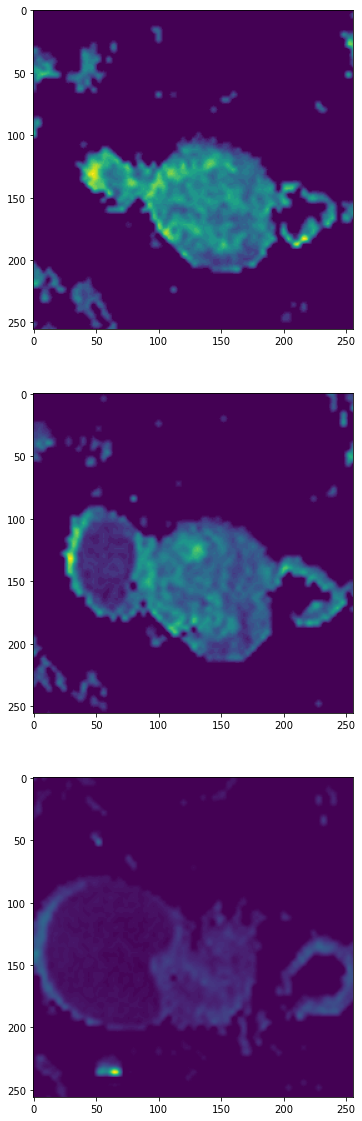

In [158]:
fig, axes = plt.subplots(3, 1, figsize = (20, 20))
axes[0].imshow(img_arr_cropped[:,:,10])
axes[1].imshow(img_arr_cropped[:,:,12])
axes[2].imshow(img_arr_cropped[:,:,18])

In [35]:
whole_prostate_paths[8]

'/raid/mpleasure/picai_workdir/picai_labels/anatomical_delineations/whole_gland/AI/Bosma22b/10008_1000008.nii.gz'

In [48]:
len(image_paths)

3885

In [49]:
missing_img = {}

for path in image_paths:
    id_1, id_2 = path.split('/')[-1].split('.')[0].split('_')[0:2]
    new_key = f'{id_1}_{id_2}'
    if new_key in picai_set:
        picai_set[new_key].append(path)
    else:
        picai_set[new_key] = [path]

for label in label_paths:
    id_ = label.split('/')[-1].split('.')[0]
    if id_ in picai_set:
        picai_set[id_].append(label)
    else:
        missing_img[id_]  = True


for whole_seg in whole_prostate_paths:
    id_ = whole_seg.split('/')[-1].split('.')[0]
    if id_ in picai_set:
        picai_set[id_].append(whole_seg)
    else:
        missing_img[id_]  = True
        
        


In [50]:
len(picai_set)

1295

In [51]:
picai_set['10000_1000000']

['/raid/mpleasure/nnUNet_raw_data/Task2201_picai_baseline/imagesTr/10000_1000000_0000.nii.gz',
 '/raid/mpleasure/nnUNet_raw_data/Task2201_picai_baseline/imagesTr/10000_1000000_0001.nii.gz',
 '/raid/mpleasure/nnUNet_raw_data/Task2201_picai_baseline/imagesTr/10000_1000000_0002.nii.gz',
 '/raid/mpleasure/nnUNet_raw_data/Task2201_picai_baseline/labelsTr/10000_1000000.nii.gz',
 '/raid/mpleasure/picai_workdir/picai_labels/anatomical_delineations/whole_gland/AI/Bosma22b/10000_1000000.nii.gz']

In [38]:
len(missing_img)

205

In [474]:
class PicaiDataset(Dataset):
    def __init__(
        self,
        image_path,
        label_path,
        get_annotation_masks = False,
        whole_prostate_path = None,
        phase = 'train',       
        patch = False
    ):
        self.image_path = image_path
        self.label_path = label_path
        self.median_voxel = np.array([0.5, 0.5, 3. ], dtype=np.float32)
        self.phase = phase
        self.patch = patch
        self.anatomical_masks = False
        self.get_annotation_masks = get_annotation_masks
        self.whole_prostate_path = whole_prostate_path

        self.image_paths = sorted(glob.glob(os.path.join(self.image_path, '*.nii.gz')))
        self.label_paths = sorted(glob.glob(os.path.join(self.label_path, '*.nii.gz')))
        if self.whole_prostate_path is None:
            self.anatomical_masks = False
            self.reshape_method = 'default'
        else:
            self.anatomical_masks = True
            self.reshape_method = 'mask'
            self.whole_prostate_paths = sorted(glob.glob(os.path.join(self.whole_prostate_path, '*.nii.gz')))
        
        # create dictionary based on patient ids in file paths
        self.picai_set = {}
        for path in self.image_paths:
            id_1, id_2 = path.split('/')[-1].split('.')[0].split('_')[0:2]
            new_key = f'{id_1}_{id_2}'
            if new_key in self.picai_set:
                self.picai_set[new_key].append(path)
            else:
                self.picai_set[new_key] = [path]

        for label in self.label_paths:
            id_ = label.split('/')[-1].split('.')[0]
            if id_ in self.picai_set:
                self.picai_set[id_].append(label)

        if self.anatomical_masks:
            for whole_seg in self.whole_prostate_paths:
                id_ = whole_seg.split('/')[-1].split('.')[0]
                if id_ in self.picai_set:
                    self.picai_set[id_].append(whole_seg)

        self.patient_keys = list(self.picai_set.keys())

    def __len__(self):
        return len(self.patient_keys)

    def __getitem__(self, idx):

        patient_id = self.patient_keys[idx]
        patient_paths = self.picai_set[patient_id]
        
        mri_paths = patient_paths[0:3]

        t2_full = nib.load(mri_paths[0])
        t2 = t2_full.get_fdata()
        adc_full = nib.load(mri_paths[1])
        adc = adc_full.get_fdata()
        highb_full = nib.load(mri_paths[2])
        highb = highb_full.get_fdata()
        
        annotation = None
        whole_prostate = None
        
        input_3mri = np.array([t2, adc, highb]).transpose((0, 2, 3, 1))
        
        if self.anatomical_masks: # check if we have segmentations of prostate provided
            whole_prostate_path = patient_paths[-1]
            whole_prostate_full = nib.load(whole_prostate_path)
            whole_prostate = whole_prostate_full.get_fdata()
            whole_prostate = whole_prostate[None, :, :, :].transpose((0, 2, 3, 1))
            
            annotation_path = patient_paths[-2]
            annotation_full = nib.load(annotation_path)
            annotation = annotation_full.get_fdata()
            annotation = annotation[None, :, :, :].transpose((0, 2, 3, 1))
            
            # crop to annatomical mask - in order to do this we make a torchio subject first
            subject = tio.Subject(
                t2 = tio.ScalarImage(mri_paths[0]),
                adc = tio.ScalarImage(mri_paths[1]),
                highb = tio.ScalarImage(mri_paths[2]),
                annotation = tio.LabelMap(annotation_path),
                whole_prostate = tio.LabelMap(whole_prostate_path)
            )
            target_shape = 256, 256, 20
            canonical = tio.ToCanonical()
            subject = canonical(subject)
            resample = tio.Resample(self.median_voxel)
            subject = resample(subject)
            crop_pad = tio.CropOrPad(target_shape, mask_name = 'whole_prostate')
            subject = crop_pad(subject)
            
            t2 = subject.t2.numpy().squeeze(axis = 0)
            adc = subject.adc.numpy().squeeze(axis = 0)
            highb = subject.highb.numpy().squeeze(axis = 0)
            annotation = subject.annotation.numpy()
            whole_prostate = subject.whole_prostate.numpy()
            input_3mri = np.array([t2, adc, highb])#.transpose((0, 2, 3, 1))
            
            data = np.concatenate((input_3mri, annotation, whole_prostate), 0)

        else:
            whole_prostate_path = None
            annotation_path = patient_paths[-1]
            annotation_full = nib.load(annotation_path)
            annotation = annotation_full.get_fdata()
            annotation = annotation[None, :, :, :].transpose((0, 2, 3, 1))
            
            # crop to prespecified area
            data = np.concatenate((input_3mri, annotation), 0)
            target_shape = 256, 256, 20
            canonical = tio.ToCanonical()
            data = canonical(data)
            resample = tio.Resample(self.median_voxel)
            data = resample(data)
            crop_pad = tio.CropOrPad(target_shape)
            data = crop_pad(data)
            
        # get cspca label
        cspca_label = (np.all(annotation == 0) == False).astype(np.uint8)
        
        
        # data augmentation for train phase
        if self.phase == 'train':
            anisotropy = tio.RandomAnisotropy(p = 0.3)
            flip = tio.RandomFlip(axes=[0,1], flip_probability = 0.5)
            #swap = tio.RandomSwap(patch_size = 4, num_iterations = 100, p = 0.5)
            spatial = tio.OneOf({
                tio.RandomAffine(scales = 0, 
                                translation = 0,
                                degrees = (10, 10, 0)): 0.5,
                tio.RandomElasticDeformation(max_displacement = (10, 10, 0)): 0.25,
            },
            p = 0.6)
            data = anisotropy(data)
            data = flip(data)
            #data = swap(data)
            data = spatial(data)
        
        # get mri data and normalize it
        input_3mir = data[0:3]
        input_3mri = input_3mri.transpose((0, 3, 1, 2))
        normalize = tio.ZNormalization()
        input_3mri = normalize(input_3mri)
        
        annotation = annotation[0].transpose((2, 0, 1)).astype(np.uint8)
        
        data_batch = {
            'input_mris':input_3mri,
            'cspca_label':cspca_label
            }
        annotation_3 = None
        anatomical_3 = None

        # option to get annotation or anatomical masks in case needed
        if self.get_annotation_masks:
            t2_annotation = input_3mri[0] * annotation
            adc_annotation = input_3mri[1] * annotation
            highb_annotation = input_3mri[2] * annotation

            annotation_3 = np.array([t2_annotation, adc_annotation, highb_annotation])
            data_batch['annotation_masks'] = annotation_3

        if self.anatomical_masks:
            whole_prostate = whole_prostate
            whole_prostate = whole_prostate[0].transpose((2, 0, 1)).astype(np.uint8)
            t2_anatomical = input_3mri[0] * whole_prostate
            adc_anatomical = input_3mri[1] * whole_prostate
            highb_anatomical = input_3mri[2] * whole_prostate

            anatomical_3 = np.array([t2_anatomical, adc_anatomical, highb_anatomical])
            data_batch['anatomical_masks'] = anatomical_3
        
        return data_batch
            

In [479]:
# path to images
image_path = '/raid/mpleasure/nnUNet_raw_data/Task2201_picai_baseline/imagesTr'
# path to annotations
label_path = '/raid/mpleasure/nnUNet_raw_data/Task2201_picai_baseline/labelsTr'
# path to anatomical annotations
whole_prostate_path = '/raid/mpleasure/picai_workdir/picai_labels/anatomical_delineations/whole_gland/AI/Bosma22b'


dataset = PicaiDataset(
        image_path = image_path,
        label_path = label_path,
        get_annotation_masks = False,
        whole_prostate_path = whole_prostate_path,
        phase = 'train',       
        patch = False)

In [480]:
dataloader_picai = DataLoader(
    dataset, 
    batch_size = 2,
    num_workers =2,
    pin_memory = False, 
    shuffle = True)

In [481]:
for i, batch in enumerate(dataloader_picai):
    print(f'finished {i}')

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/raid/mpleasure/anaconda3/envs/picai_dev/lib/python3.10/site-packages/torchio/data/subject.py", line 310, in check_consistent_space
    self.check_consistent_attribute('direction')
  File "/raid/mpleasure/anaconda3/envs/picai_dev/lib/python3.10/site-packages/torchio/data/subject.py", line 287, in check_consistent_attribute
    raise RuntimeError(message)
RuntimeError: More than one value for "direction" found in subject images:
{'t2': (0.998137072380533,
        -7.431756411521275e-11,
        -0.06101135150413536,
        0.0021332394321534995,
        0.9993885503415579,
        0.03489949404085851,
        0.06097404389692319,
        -0.034964631360838626,
        0.9975267616978157),
 'whole_prostate': (0.9981370990858413,
                    2.5471570594876904e-05,
                    -0.061010909314877744,
                    0.002107767817255575,
                    0.9993885772233689,
                    0.0349002741565553,
                    0.06097449256312099,
                    -0.03496385371565263,
                    0.9975267614497213)}

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/raid/mpleasure/anaconda3/envs/picai_dev/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/raid/mpleasure/anaconda3/envs/picai_dev/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/raid/mpleasure/anaconda3/envs/picai_dev/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 49, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_2565154/1825277976.py", line 100, in __getitem__
    subject = crop_pad(subject)
  File "/raid/mpleasure/anaconda3/envs/picai_dev/lib/python3.10/site-packages/torchio/transforms/transform.py", line 158, in __call__
    transformed = self.apply_transform(subject)
  File "/raid/mpleasure/anaconda3/envs/picai_dev/lib/python3.10/site-packages/torchio/transforms/preprocessing/spatial/crop_or_pad.py", line 278, in apply_transform
    subject.check_consistent_space()
  File "/raid/mpleasure/anaconda3/envs/picai_dev/lib/python3.10/site-packages/torchio/data/subject.py", line 320, in check_consistent_space
    raise RuntimeError(message) from e
RuntimeError: As described above, some images in the subject are not in the same space. You probably can use the transforms ToCanonical and Resample to fix this, as explained at https://github.com/fepegar/torchio/issues/647#issuecomment-913025695
